In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
from torch.utils.tensorboard import SummaryWriter
from matplotlib import pyplot as plt
import os
from PIL import Image
import random
import datetime
import time
import albumentations as A
import cv2
import shutil


2025-04-15 15:12:56.742994: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744719176.755865  304106 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744719176.759525  304106 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-15 15:12:56.774354: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
folder_path = "BCI_dataset/train/"
image_paths = []
class_names = {"0": "0", "1+": "1", "2+": "2", "3+": "3"}
labels = []
for f in os.listdir(folder_path):
    if f.endswith(("png", "jpg", "jpeg")):
        class_name = f.split("_")[2].split(".")[0]
        # print(f"class name: {class_name} file name: {f} path: {os.path.join(folder_path, f)}")
        image_paths.append(os.path.join(folder_path, f))
        labels.append(class_names[class_name])

data_set = []
valid_index_set = []
for c in class_names.values():
    l = [i for i, x in enumerate(labels) if x == c]
    print(f"{c}: {len(l)}")
    t_size = int(len(l) * 0.8)
    data_set.extend([i for i in l[:t_size]])
    valid_index_set.extend([i for i in l[t_size:]])

random.shuffle(data_set)
random.shuffle(valid_index_set)

train_dataset = [image_paths[i] for i in data_set]
val_dataset = [image_paths[i] for i in valid_index_set]
train_labels = [labels[i] for i in data_set]
valid_labels = [labels[i] for i in valid_index_set]



0: 202
1: 919
2: 1697
3: 1078


In [3]:
class BCI_Dataset(Dataset):
    def __init__(
        self,
        root_dir: str,
        set_type: str,
        transforms=None,
        wanted_counts: tuple = (),
        wanted_classes: tuple = (),
        is_augmentation_active: bool = False,
    ):
        self.transforms = transforms
        self.image_paths = []
        self.labels = []

        transform_alb = A.Compose(
    [
        A.RandomCrop(width=256, height=256),
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.2),
        A.Rotate(limit=10, p=0.5),  # Sadece döndürme
        A.Affine(
            scale=(0.9, 1.1),  # Ölçeklendirme
            translate_percent=(0.1, 0.1),  # Kaydırma
            rotate=(-10, 10),  # Döndürme
            p=0.5,  # Uygulama olasılığı
        ),
    ]
)

        class_names = {"0": "0", "1+": "1", "2+": "2", "3+": "3"}

        for f in os.listdir(root_dir):
            if f.endswith(("png", "jpg", "jpeg")):
                class_name = f.split("_")[2].split(".")[0]
                # print(f"class name: {class_name} file name: {f} path: {os.path.join(root_dir, f)}")
                self.image_paths.append(os.path.join(root_dir, f))
                self.labels.append(class_names[class_name])

        if set_type != "test":
            indexes = []
            for c in class_names.values():
                l = [i for i, x in enumerate(self.labels) if x == c]
                t_size = int(len(l) * 0.8)
                if set_type == "train":
                    indexes.extend([i for i in l[:t_size]])
                elif set_type == "val":
                    indexes.extend([i for i in l[t_size:]])
            random.shuffle(indexes)
            self.image_paths = [self.image_paths[i] for i in indexes]
            self.labels = [self.labels[i] for i in indexes]

        if is_augmentation_active and set_type == "train":
            if os.path.exists(os.path.join(root_dir, "ek_veri")):
                shutil.rmtree(os.path.join(root_dir, "ek_veri"))
            os.makedirs(os.path.join(root_dir, "ek_veri"))
            for i, class_name in enumerate(wanted_classes):  # wanted_classes içinde gez
                filtered_indices = [
                    j for j, x in enumerate(self.labels) if x == class_name
                ]  # Sınıf adıyla karşılaştır
                k = (
                    len(filtered_indices)
                    if len(filtered_indices) > wanted_counts[i]
                    else wanted_counts[i] - len(filtered_indices)
                )
                rnd_images_idx = random.choices(filtered_indices, k=k)
                for j in rnd_images_idx:
                    img = cv2.imread(self.image_paths[j])
                    transformed = transform_alb(image=img)
                    transformed_image = transformed["image"]
                    lb = self.image_paths[j].split("/")[-1]
                    new_image_path = os.path.join(root_dir, "ek_veri", f"{j}_{lb}.png")
                    cv2.imwrite(new_image_path, transformed_image)
                    self.image_paths.append(new_image_path)
                    self.labels.append(class_name)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        label = self.labels[idx]

        if self.transforms:
            image = self.transforms(image)

        return image, torch.tensor(int(label), dtype=torch.long)

In [7]:
BATCH_SIZE = 32


data_transform = transforms.Compose([
    transforms.Resize((1024, 1024)),
    transforms.ToTensor()
    ])

p = "BCI_dataset/"

train_dataset = BCI_Dataset(p + "train/", "train", transforms=data_transform)
val_dataset = BCI_Dataset(p + "train/", "val", transforms=data_transform)
test_dataset = BCI_Dataset(p + "test/", "test", transforms=data_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

dataset_sizes = {"train": len(train_dataset), "val": len(val_dataset)}

print(f"train dataset size: {dataset_sizes['train']} val dataset size: {dataset_sizes['val']}")

data_loader = {
    "train": train_loader,
    "val": valid_loader,
    "test": test_loader
}


train dataset size: 3115 val dataset size: 781


In [4]:
data_transform = transforms.Compose(
    [transforms.Resize((512, 512)), transforms.ToTensor()]
)

p = "BCI_dataset/"

train_dataset = BCI_Dataset(
    p + "train/",
    "train",
    transforms=data_transform,
    wanted_counts=(1400, 1400, 1400, 1400),
    wanted_classes=("0", "1", "2", "3"),
    is_augmentation_active=True,
)
val_dataset = BCI_Dataset(
    p + "train/",
    "val",
    transforms=data_transform,
)
test_dataset = BCI_Dataset(
    p + "test/",
    "test",
    transforms=data_transform,
)

In [5]:
BATCH_SIZE = 128

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

dataset_sizes = {"train": len(train_dataset), "val": len(val_dataset)}

print(
    f"train dataset size: {dataset_sizes['train']} val dataset size: {dataset_sizes['val']}"
)

data_loader = {"train": train_loader, "val": valid_loader, "test": test_loader}

train dataset size: 5600 val dataset size: 781


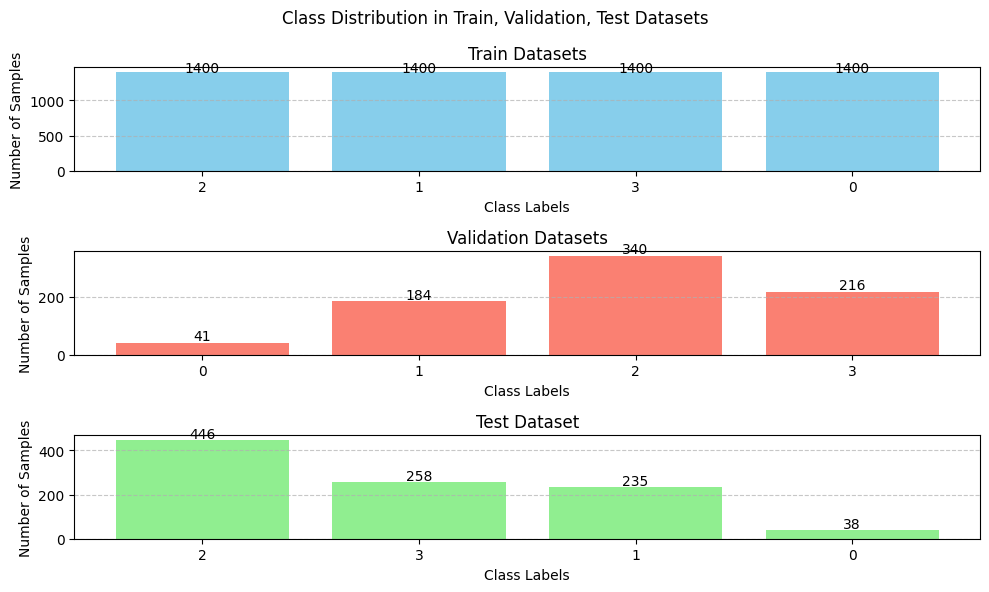

In [15]:
from collections import Counter
import matplotlib.pyplot as plt

# Combine all datasets
train_labels_combined = train_dataset.labels
valid_labels_combined = val_dataset.labels

# Count the number of samples in each class
train_class_counts = Counter(train_labels_combined)
valid_class_counts = Counter(valid_labels_combined)
test_class_counts = Counter(test_dataset.labels)


fig, ax = plt.subplots(3, 1, figsize=(10, 6))
fig.suptitle("Class Distribution in Train, Validation, Test Datasets")
colors = ["skyblue", "salmon", "lightgreen"]
titles = ["Train Datasets", "Validation Datasets", "Test Dataset"]
for i, counts in enumerate([train_class_counts, valid_class_counts, test_class_counts]):
    ax[i].bar(counts.keys(), counts.values(), color=colors[i])
    for j, count in enumerate(counts.values()):
        ax[i].text(j, count + 10, str(count), ha="center", fontsize=10)
    ax[i].set_xlabel("Class Labels")
    ax[i].set_ylabel("Number of Samples")
    ax[i].set_title(titles[i])
    ax[i].grid(axis="y", linestyle="--", alpha=0.7)

plt.tight_layout()
plt.show()

In [6]:
class BCI_Cnn(nn.Module):
    def __init__(self):
        super(BCI_Cnn, self).__init__()
        self.conv1 = nn.Conv2d(3, 8, kernel_size=3, stride=1, padding=1) # -2
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1) # -2
        self.conv3 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)  # -2
        self.conv4 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)  # -2

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(64 * 32 * 32, 64)  # Adjusted for 224x224 input size
        self.fc2 = nn.Linear(64, 128)
        self.fc3 = nn.Linear(128, 256)
        self.fc4 = nn.Linear(256, 4)

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = self.pool(self.relu(self.conv4(x)))  # Updated to conv4

        x = x.view(x.shape[0], -1)  # Flatten
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [4]:
from math import ceil

input_size = 512
ceil((ceil((ceil(((ceil(input_size - 2) / 2) - 2) / 2) - 2) / 2) - 2) / 2) + 1

32

In [ ]:
NUM_EPOCHS = 100
LEARNING_RATE = 0.001
L2_REG = 1e-5

experiment_name = "BCI_CNN"

log_dir = f"runs/{experiment_name}_{datetime.datetime.now().strftime('%Y%m%d-%H%M%S')}"
writer = SummaryWriter(log_dir)

since = time.time()

model = BCI_Cnn()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=L2_REG)

best_val_loss = float("inf")

for epoch in range(NUM_EPOCHS):
    print(f'Epoch {epoch + 1}/{NUM_EPOCHS}')
    print('-' * 10)

    for state in ["train", "val"]:
        if state == "train":
            model.train()
        else:
            model.eval()
        
        running_loss = 0.0
        running_corrects = 0
        for images, labels in data_loader[state]:
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(state == "train"):
                outputs = model(images)
                loss = criterion(outputs, labels)

                if state == "train":
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data)
    
        epoch_loss = running_loss / dataset_sizes[state]
        epoch_acc = running_corrects.double() / dataset_sizes[state]
        print(f'{state} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
        writer.add_scalar(f"{state} Loss", epoch_loss, epoch)
        writer.add_scalar(f"Acc", epoch_acc, epoch)

        if state == "val" and epoch_loss < best_val_loss:
            best_val_loss = epoch_loss
            torch.save(model.state_dict(), f"{log_dir}/best_model.pth")
            print("Best model saved!")

    time_elapsed = time.time() - since
    print(f'Time elapsed: {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    since = time.time()

torch.save(model.state_dict(), f"{log_dir}/last_model.pth")
writer.close()
print("Training complete!")

In [7]:
NUM_EPOCHS = 20
LEARNING_RATE = 0.001
L2_REG = 1e-5

experiment_name = "BCI_CNN"
experiment_num = 4

log_dir = f"runs/{experiment_name}_{experiment_num}"
writer = SummaryWriter(log_dir)
since = time.time()

model = BCI_Cnn()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=L2_REG)

train_losses = []
val_losses = []
val_accuracies = []

best_val_loss = float("inf")
patience = 5
early_stopping_counter = 0
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, "min", patience=3, factor=0.5, verbose=True
)

for epoch in range(NUM_EPOCHS):
    print("-" * 10)
    print(f"Epoch {epoch + 1}/{NUM_EPOCHS}")
    print("-" * 10)

    for state in ["train", "val"]:
        if state == "train":
            model.train()
        else:
            model.eval()

        running_loss = 0.0
        running_corrects = 0
        for images, labels in data_loader[state]:
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(state == "train"):
                outputs = model(images)
                loss = criterion(outputs, labels)

                if state == "train":
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / dataset_sizes[state]
        epoch_acc = running_corrects.double() / dataset_sizes[state]

        if state == "train":
            train_losses.append(epoch_loss)
        else:
            val_losses.append(epoch_loss)
            val_accuracies.append(epoch_acc.item())
            scheduler.step(epoch_loss)

            if epoch_loss < best_val_loss:
                best_val_loss = epoch_loss
                torch.save(model.state_dict(), f"{log_dir}/best_model.pth")
                print("Best model saved!")
                early_stopping_counter = 0

            l3_loss = val_losses[-3:]
            if len(l3_loss) > 0 and sum(l3_loss) / len(l3_loss):
                early_stopping_counter += 1
                if early_stopping_counter >= patience:
                    print(f"Early stopping at epoch {epoch + 1}")
                    torch.save(model.state_dict(), f"{log_dir}/early_stopped_model.pth")
                    writer.close()
                    break

        print(f"{state} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")
        writer.add_scalar(f"{state} Loss", epoch_loss, epoch)
        writer.add_scalar(f"Acc", epoch_acc, epoch)


    time_elapsed = time.time() - since
    print(f"Time elapsed: {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s")
    since = time.time()

torch.save(model.state_dict(), f"{log_dir}/last_model.pth")
writer.close()
print("Training complete!")

/home/bismih/miniconda3/envs/d2l/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


----------
Epoch 1/20
----------
train Loss: 1.3004 Acc: 0.3604
Best model saved!
val Loss: 1.3565 Acc: 0.3047
Time elapsed: 1m 11s
----------
Epoch 2/20
----------
train Loss: 1.1836 Acc: 0.4514
Best model saved!
val Loss: 1.0437 Acc: 0.5403
Time elapsed: 1m 9s
----------
Epoch 3/20
----------
train Loss: 1.1081 Acc: 0.4907
val Loss: 1.1098 Acc: 0.5250
Time elapsed: 1m 11s
----------
Epoch 4/20
----------
train Loss: 1.0677 Acc: 0.5054
Best model saved!
val Loss: 0.9715 Acc: 0.5595
Time elapsed: 1m 12s
----------
Epoch 5/20
----------
train Loss: 1.0274 Acc: 0.5262
Best model saved!
val Loss: 0.9527 Acc: 0.5147
Time elapsed: 1m 10s
----------
Epoch 6/20
----------
train Loss: 0.9813 Acc: 0.5382
Best model saved!
val Loss: 0.9316 Acc: 0.5519
Time elapsed: 1m 10s
----------
Epoch 7/20
----------
train Loss: 0.9573 Acc: 0.5579
val Loss: 0.9335 Acc: 0.5570
Time elapsed: 1m 9s
----------
Epoch 8/20
----------
train Loss: 0.9468 Acc: 0.5577
val Loss: 0.9522 Acc: 0.5365
Time elapsed: 1m 10s


In [11]:
l = []
print(l[-3:])
print(sum(l[-3:])/len(l[-3:]))


[]


ZeroDivisionError: division by zero

In [ ]:
plt.figure(figsize=(12, 4))

# Kayıp grafiği
plt.subplot(1, 2, 1)
plt.plot(range(1, NUM_EPOCHS+1), train_losses, label='Eğitim Kaybı')
plt.plot(range(1, NUM_EPOCHS+1), val_losses, label='Doğrulama Kaybı')
plt.xlabel('Epoch')
plt.ylabel('Kayıp')
plt.title('Eğitim ve Doğrulama Kayıpları')
plt.legend()
plt.grid(True)

# Doğruluk grafiği
plt.subplot(1, 2, 2)
plt.plot(range(1, NUM_EPOCHS+1), val_accuracies, label='Doğrulama Doğruluğu', color='green')
plt.xlabel('Epoch')
plt.ylabel('Doğruluk (%)')
plt.title('Doğrulama Doğruluğu')
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
log_dir = f"runs/{experiment_name}_{datetime.datetime.now().strftime('%Y%m%d-%H%M%S')}"

best_model = BCI_Cnn()
best_model.load_state_dict(torch.load(f"{log_dir}/best_model.pth"))
best_model.to(device)
best_model.eval()



correct = 0
total = 0

class_correct = [0] * 4
class_total = [0] * 4

with torch.no_grad():
    for images, labels in data_loader["test"]:
        images = images.to(device)
        labels = labels.to(device)

        outputs = best_model(images)
        _, predicted = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        for i in range(len(labels)):
            label = labels[i].item()
            class_correct[label] += (predicted[i] == label).item()
            class_total[label] += 1
            if predicted[i] == label:
                class_correct[label] += 1

acc = 100 * correct / total
print(f"Test Doğruluğu: {acc:.2f}%")
for i in range(4):
    class_acc = 100 * class_correct[i] / class_total[i]
    print(f"Test Doğruluğu {i}: {class_acc:.2f}%")

plt.figure(figsize=(10, 6))
class_acc = [100 * class_correct[i] / class_total[i] for i in range(4)]
plt.bar(range(4), class_acc)
plt.xlabel('Sınıf')
plt.ylabel('Doğruluk (%)')
plt.title('Sınıf Doğrulukları')
plt.xticks(range(4), [f"Sınıf {i}" for i in range(4)])
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [13]:
experiment_name = "BCI_CNN"
emxperiment_no = 1
log_dir = f"runs/{experiment_name}_{datetime.datetime.now().strftime('%Y%m%d-%H%M%S')}"
best_model = BCI_Cnn()
best_model.load_state_dict(torch.load(f"runs/BCI_CNN_20250414-232117/best_model.pth"))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
best_model.to(device)
best_model.eval()

BCI_Cnn(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=262144, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=4, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
)

In [17]:
correct = 0
total = 0

with torch.no_grad():
    for images, labels in data_loader["test"]:
        images = images.to(device)
        labels = labels.to(device)

        outputs = best_model(images)
        _, predicted = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()
test_acc = 100 * correct / total

In [18]:
test_acc

58.239508700102355

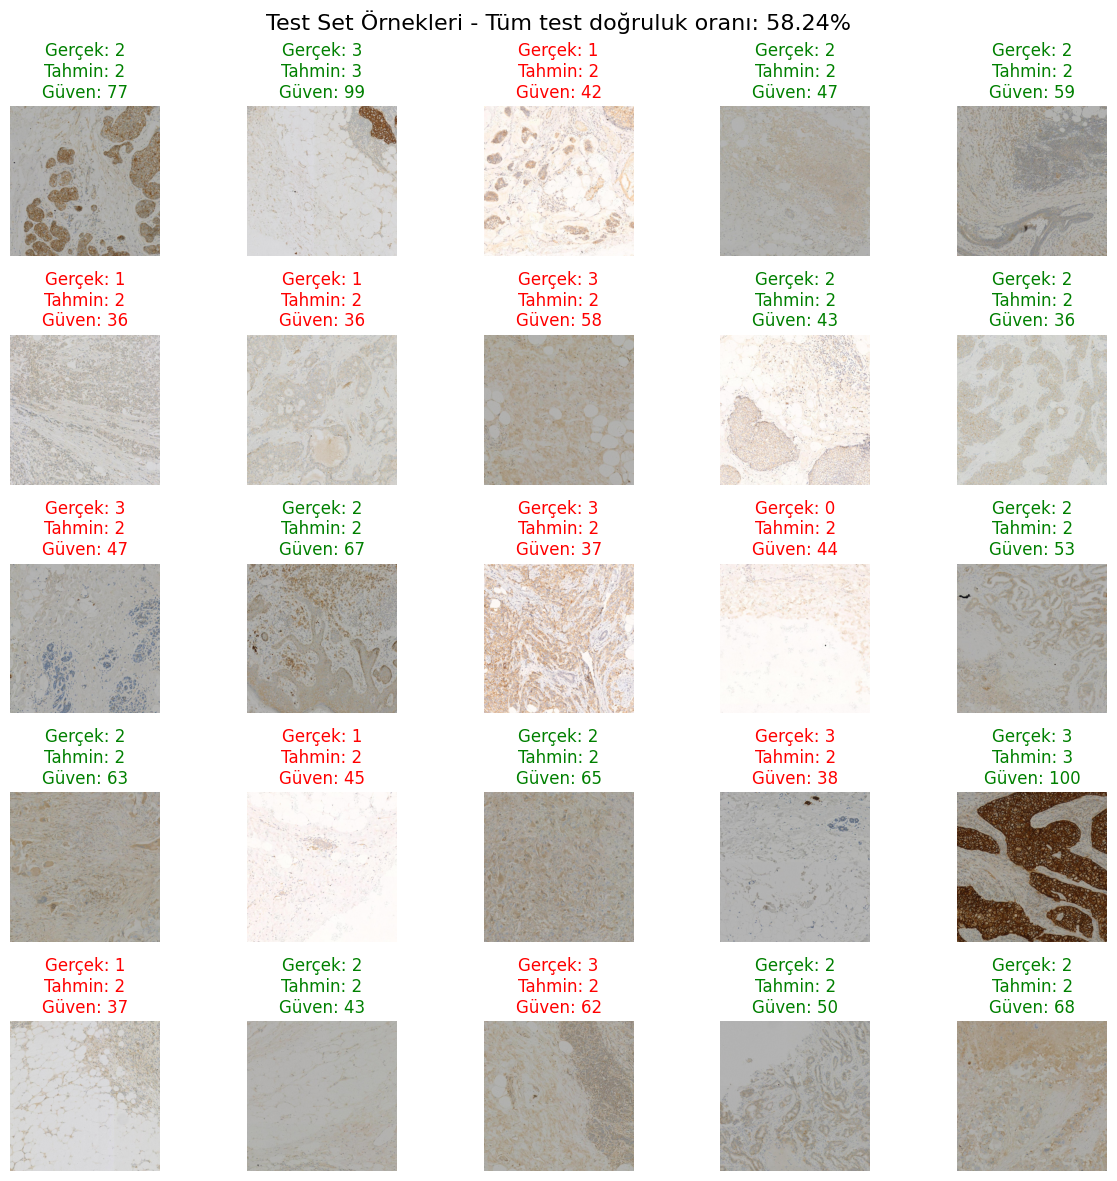

In [ ]:
data_iter = iter(test_loader)
images, labels = next(data_iter)

indices = torch.randperm(len(images))[:25]
sample_images = images[indices].to(device)
sample_labels = labels[indices].to(device)

with torch.no_grad():
    outputs = best_model(sample_images)
    probs = torch.softmax(outputs, dim=1)
    _, preds = torch.max(outputs, 1)


fig, axes = plt.subplots(5, 5, figsize=(12, 12))
fig.suptitle(f"Test Set Örnekleri - Tüm testler doğruluk oranı: {test_acc:.2f}%", fontsize=16)
for i, ax in enumerate(axes.flat):
    img = sample_images[i].cpu().numpy().squeeze()
    color = "green" if preds[i] == sample_labels[i] else "red"
    ax.imshow(img.transpose(1, 2, 0))
    ax.set_title(
        f"Gerçek: {sample_labels[i].item()}\nTahmin: {preds[i].item()}\nGüven: {int(probs[i][preds[i]]*100)}",
        color=color,
    )
    ax.axis("off")



plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

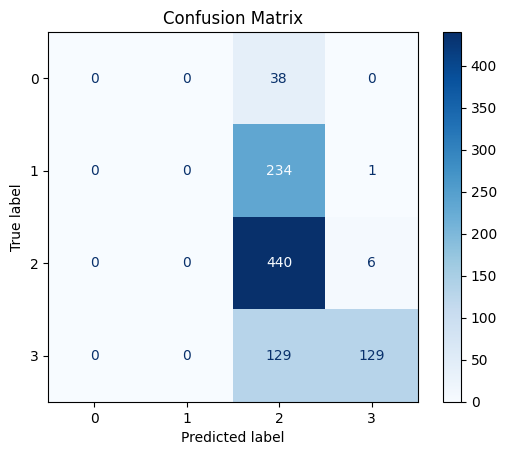

In [29]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Initialize variables to store true labels and predictions
all_labels = []
all_preds = []

# Collect predictions and true labels from the test set
with torch.no_grad():
    for images, labels in data_loader["test"]:
        images = images.to(device)
        labels = labels.to(device)

        outputs = best_model(images)
        _, predicted = torch.max(outputs, 1)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

# Generate the confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1, 2, 3])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [6]:
%load_ext tensorboard
%tensorboard --logdir runs